In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import os
import glob

In [2]:
folder_path = './db/all/'
file_extension = '.csv'

file_paths = glob.glob(os.path.join(folder_path, f'*{file_extension}'))
file_paths = sorted(file_paths, reverse=True)
print(file_paths)

['./db/all/2022-^FCHI.csv', './db/all/2022-XFAB.PA.csv', './db/all/2022-WLN.PA.csv', './db/all/2022-WAVE.PA.csv', './db/all/2022-VRLA.PA.csv', './db/all/2022-VMX.PA.csv', './db/all/2022-VLTSA.PA.csv', './db/all/2022-VLA.PA.csv', './db/all/2022-VK.PA.csv', './db/all/2022-VIV.PA.csv', './db/all/2022-VIRP.PA.csv', './db/all/2022-VIE.PA.csv', './db/all/2022-VETO.PA.csv', './db/all/2022-VCT.PA.csv', './db/all/2022-VAC.PA.csv', './db/all/2022-URW.AS.csv', './db/all/2022-UCG.MI.csv', './db/all/2022-UBI.PA.csv', './db/all/2022-TTE.PA.csv', './db/all/2022-TRI.PA.csv', './db/all/2022-TNG.PA.csv', './db/all/2022-TKTT.PA.csv', './db/all/2022-TKO.PA.csv', './db/all/2022-TIT.MI.csv', './db/all/2022-TIS.MI.csv', './db/all/2022-TFI.PA.csv', './db/all/2022-TEP.PA.csv', './db/all/2022-SW.PA.csv', './db/all/2022-SU.PA.csv', './db/all/2022-STM.PA.csv', './db/all/2022-STF.PA.csv', './db/all/2022-SRS.MI.csv', './db/all/2022-SRP.PA.csv', './db/all/2022-SRG.MI.csv', './db/all/2022-SPM.MI.csv', './db/all/2022-

In [3]:
def divide_year_into_portions(n, year):
    start_month = 1
    end_month = 12
    total_days = (dt.date(year, end_month, 31) - dt.date(year, start_month, 1)).days + 1

    portion_size = total_days // n

    dates = []
    current_date = dt.date(year, start_month, 1)
    
    for i in range(n):
        start_date = current_date
        end_date = start_date + dt.timedelta(days=portion_size - 1)

        if i == n - 1:  # Last portion, adjust end date to the last day of the year
            end_date = dt.date(year, end_month, 31)

        dates.append((start_date, end_date))

        current_date = end_date + dt.timedelta(days=1)

    return dates

In [4]:
yearly_portions = 5

data_list = []
tickers_list = []

for file_path in file_paths:
    file_name = file_path.replace(folder_path, '')
    year = int(file_name[0:4])
    ticker = file_name[5:].replace(file_extension, '')

    ticker_year_df = pd.read_csv(file_path)
    ticker_year_df['Date'] = pd.to_datetime(ticker_year_df['Date'])
    ticker_year_df['Date'] = ticker_year_df['Date'].dt.date

    portions = divide_year_into_portions(yearly_portions, year)

    for nth_portion, portion in enumerate(portions, start=1):
        start_date, end_date = portion

        portion_df = ticker_year_df[(ticker_year_df['Date'] >= start_date) & (ticker_year_df['Date'] <= end_date)]
        portion_df = portion_df['Close']

        index = f'{ticker}-{year}-{nth_portion}'

        daily_profit_df = portion_df.pct_change()
        daily_profit_df = daily_profit_df.dropna()

        profit = daily_profit_df.mean() * len(daily_profit_df) * 100
        volatility = daily_profit_df.std() * len(daily_profit_df) * 100

        data_list.append({'index': index, 'year': year, 'nth_portion': nth_portion,
                          'ticker': ticker, 'profit': profit, 'volatility': volatility})
    
    tickers_list.append(ticker)

df = pd.DataFrame(data_list)

In [5]:
df = df.dropna()
df = df.sort_values(by=['index'])
df['previous_profit'] = df['profit'].shift(periods=1)
df['profit_ratio'] = df['profit'] / df['previous_profit']

min_years = df.groupby('ticker')['year'].transform('min')
df = df[df['year'] != min_years]

print(df.to_markdown())

|       | index           |   year |   nth_portion | ticker   |        profit |   volatility |   previous_profit |    profit_ratio |
|------:|:----------------|-------:|--------------:|:---------|--------------:|-------------:|------------------:|----------------:|
| 23310 | A2A.MI-2001-1   |   2001 |             1 | A2A.MI   |  -15.0534     |    149.662   |      -23.8166     |     0.632056    |
| 23311 | A2A.MI-2001-2   |   2001 |             2 | A2A.MI   |    9.74598    |    103.667   |      -15.0534     |    -0.647428    |
| 23312 | A2A.MI-2001-3   |   2001 |             3 | A2A.MI   |  -19.2716     |    104.575   |        9.74598    |    -1.97739     |
| 23313 | A2A.MI-2001-4   |   2001 |             4 | A2A.MI   |  -16.4558     |    130.972   |      -19.2716     |     0.853889    |
| 23314 | A2A.MI-2001-5   |   2001 |             5 | A2A.MI   |   11.9966     |     98.7346  |      -16.4558     |    -0.729017    |
| 22250 | A2A.MI-2002-1   |   2002 |             1 | A2A.MI   |  -12.

In [6]:
df = df.sort_values(by=['previous_profit'], ascending=False)
print(df.to_markdown())

|       | index           |   year |   nth_portion | ticker   |        profit |   volatility |   previous_profit |    profit_ratio |
|------:|:----------------|-------:|--------------:|:---------|--------------:|-------------:|------------------:|----------------:|
| 22546 | RF.PA-2001-2    |   2001 |             2 | RF.PA    |   -3.13317    |    159.563   |      806.162      |    -0.00388652  |
| 18035 | WAVE.PA-2005-1  |   2005 |             1 | WAVE.PA  |   21.2564     |     84.4778  |      323.659      |     0.0656753   |
| 14296 | JCQ.PA-2009-2   |   2009 |             2 | JCQ.PA   |   11.158      |    148.787   |      306.201      |     0.0364402   |
| 18038 | WAVE.PA-2005-4  |   2005 |             4 | WAVE.PA  |    2.7995     |     72.7033  |      244.77       |     0.0114373   |
| 16975 | WAVE.PA-2006-1  |   2006 |             1 | WAVE.PA  |    3.66953    |     57.5229  |      226.731      |     0.0161845   |
| 18037 | WAVE.PA-2005-3  |   2005 |             3 | WAVE.PA  |  244.

In [7]:
def get_mean(df):
    return (pow(1 + (df["profit"].mean() / 100), yearly_portions) - 1) * 100

def get_median(df):
    return (pow(1 + (df["profit"].median() / 100), yearly_portions) - 1) * 100

Buying last portion's big profit values

In [8]:
threshold_pct = 60
big_profit_df = df.drop(df[df['previous_profit'] < threshold_pct].index)
big_profit_df = big_profit_df.sort_values(by=['year'])

print(f'yearly mean: {get_mean(big_profit_df)}')
print(f'yearly median: {get_median(big_profit_df)}')
print(f'std dev: {big_profit_df["profit"].std()}')

print(big_profit_df.groupby('year')['profit'].agg(['mean', 'median']))

yearly mean: 22.40690272774519
yearly median: -4.653652528669305
std dev: 36.21364539226225
           mean     median
year                      
2001  -9.309661  -9.309661
2002  -1.601477  -1.601477
2003   4.759258  -4.990841
2004   7.477755   1.111289
2005  59.552544  26.308726
2006   7.058639  -7.894785
2007 -10.781182 -10.781182
2008  -9.021413  -9.021413
2009   5.975332   4.246360
2010  67.277882  67.277882
2011   0.416829   0.416829
2012 -15.502615 -25.211363
2013 -10.662789 -15.242215
2014   4.409295  -1.401918
2015 -28.158411 -15.677156
2016  -6.424643  -6.424643
2017   3.030116   3.005051
2018  -3.802532   1.312420
2019 -14.055664 -13.242981
2020   4.557521  -3.350040
2021   2.564146   2.798375
2022 -29.530979 -35.032006


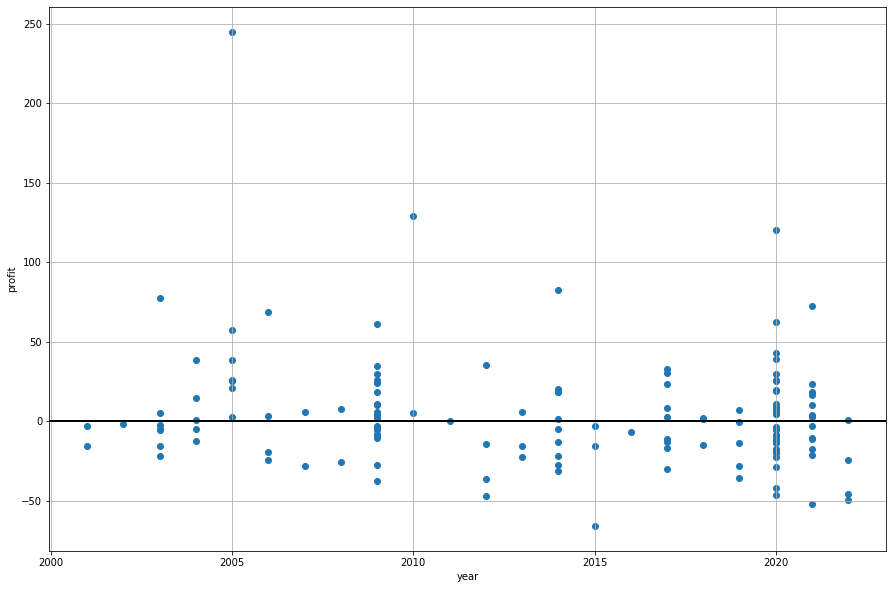

In [9]:
plt.rcParams["figure.figsize"] = (15, 10)

fig, ax = plt.subplots()
ax.scatter(x=big_profit_df['year'], y=big_profit_df['profit'])
ax.set_xlabel('year')
ax.set_ylabel('profit')
ax.axhline(0, color='black', linewidth=2)

plt.grid()
plt.show()


Buying last portion's top n values

In [10]:
top_n = 12
top_n_profit_df = df.groupby('year').apply(lambda x: x.nlargest(top_n, 'previous_profit')).reset_index(drop=True)

print(f'yearly mean: {get_mean(top_n_profit_df)}')
print(f'yearly median: {get_median(top_n_profit_df)}')
print(f'std dev: {top_n_profit_df["profit"].std()}')

print(top_n_profit_df.groupby('year')['profit'].agg(['mean', 'median']))

yearly mean: 20.46900760685737
yearly median: 1.5666246056375233
std dev: 30.33924259709314
           mean     median
year                      
2001  13.111833   3.092607
2002   0.886042   1.991491
2003   0.756081  -5.084439
2004  10.512973   4.216790
2005  37.778125  19.905314
2006   4.528287  -1.500411
2007  -3.615309  -5.997899
2008 -10.407513 -17.584269
2009   9.233718   5.461929
2010  21.445308  14.822155
2011   4.758156  -4.437532
2012 -15.042810 -17.214186
2013  -3.829702  -3.253282
2014   1.095303  -5.642982
2015  -3.024892  -1.375114
2016   5.169874   3.680688
2017  10.128974   5.862592
2018   7.048776  -0.808876
2019 -10.656208 -13.805235
2020   1.730832  -0.795178
2021   7.095330   3.416161
2022  -5.220364  -0.687578


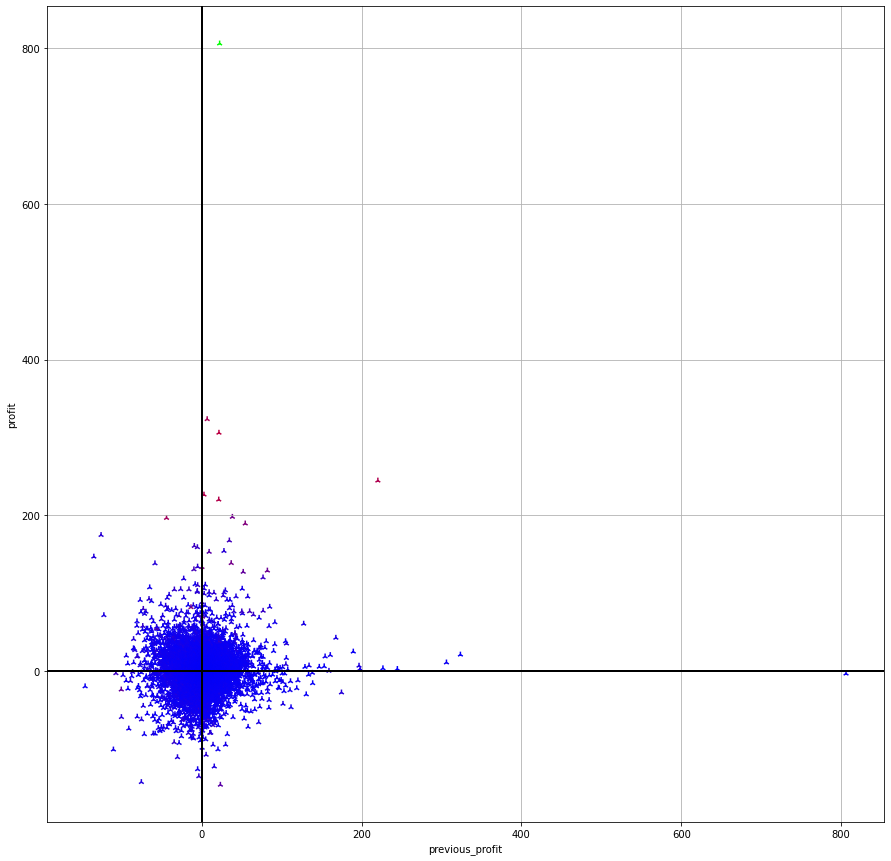

In [11]:
plt.rcParams["figure.figsize"] = (15, 15)

fig, ax = plt.subplots()
ax.scatter(x=df['previous_profit'], y=df['profit'], marker='2', c=df.volatility, cmap='brg')
ax.set_xlabel('previous_profit')
ax.set_ylabel('profit')
ax.axhline(0, color='black', linewidth=2)
ax.axvline(0, color='black', linewidth=2)

plt.grid()
plt.show()

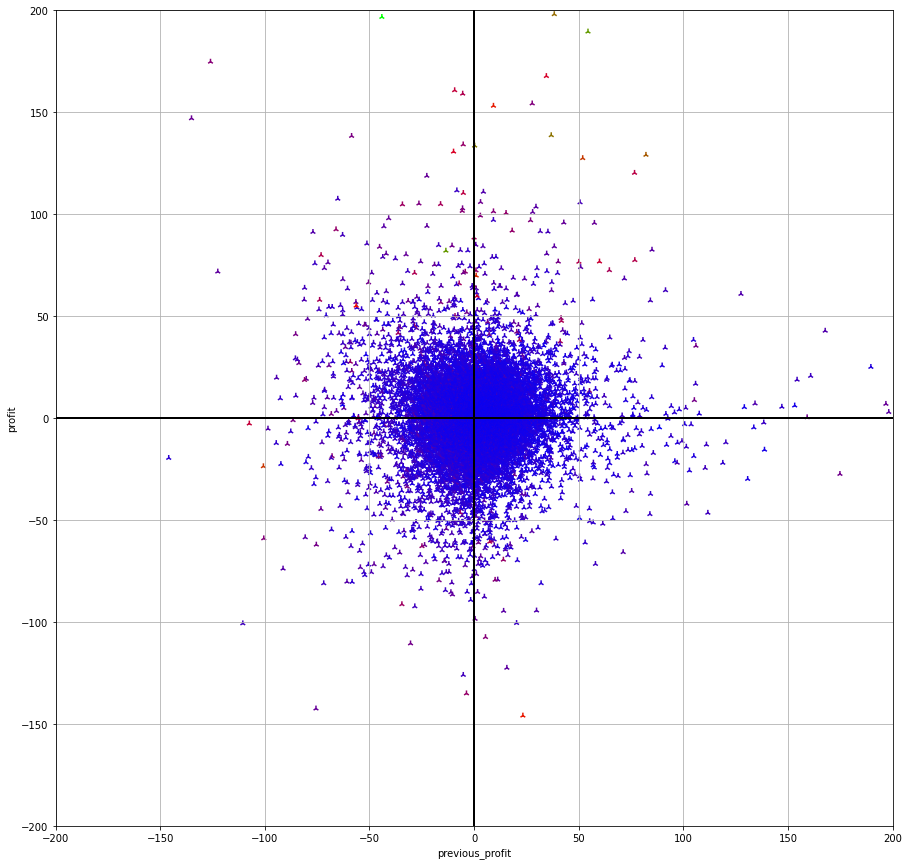

In [12]:
limit1 = 200
df1 = df.drop(df[(df.profit < -limit1) | (df.profit > limit1) | (df.previous_profit < -limit1) | (df.previous_profit > limit1)].index)

plt.rcParams["figure.figsize"] = (15, 15)

fig, ax = plt.subplots()
ax.scatter(x=df1['previous_profit'], y=df1['profit'], marker='2', c=df1.volatility, cmap='brg')
ax.set_xlabel('previous_profit')
ax.set_ylabel('profit')
ax.axhline(0, color='black', linewidth=2)
ax.axvline(0, color='black', linewidth=2)

plt.xlim([-limit1, limit1])
plt.ylim([-limit1, limit1])
plt.grid()
plt.show()